In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from models_explainability.ExplainableModels import ExplainableModel
from models_explainability.test_agreements import batch_agreement
from models_explainability.agreement import attributions_preprocessing
import os
from matplotlib import pyplot as plt
import matplotlib as mtpl
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import List
import numpy as np


/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/srepetto/miniconda3/envs/XAI-for-Healthcare/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
new_cwd = os.path.join(os.getcwd(), "models_explainability")
os.chdir(new_cwd)
print("working in: ",os.getcwd())

working in:  /data/srepetto/XAI-for-Healthcare-paper_version/models_explainability


In [4]:
#parameters inizialitation
model_name = 'resnet50'
train_data_name = 'dermamnist'
data_name = 'dermamnist'
corruption ='contrast_down'
data_name_corrupted = f'{data_name}_corrupted_{corruption}'
algorithm ='DeepLift'
n_classes = 7
agreement_measure ='l2'
batch_size = 64


In [5]:
##load model
model = ExplainableModel(model_name = model_name,
                                        train_data_name = train_data_name,
                                        n_classes = n_classes)

loading:../models_training/resnet50/output/dermamnist/checkpoint_best.pth


/data/srepetto/XAI-for-Healthcare-paper_version/models_explainability/ExplainableModels.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model = torch.load(m

In [6]:
##load data
data_clean=ExplainableModel.load_data(data_name=data_name,
                                        data_split="test")

Dataset dermamnist split test loaded


In [7]:
#load original explanations
attributions_clean = model.explain_dataset(algorithm=algorithm,
                        data_name=data_name,
                        data_split="test", batch_size=batch_size,)


Attributions for DeepLift already exist. (resnet50_attributions/dermamnist/dermamnist_test/)


In [8]:
##load corrupted data
data_corruppted=ExplainableModel.load_data(data_name=data_name_corrupted,
                                        data_split="test")


Dataset dermamnist_corrupted_contrast_down split test loaded


In [8]:
#load corrupted explanations
attributions_corrupted = model.explain_dataset(algorithm=algorithm,
                        data_name=data_name_corrupted,
                        data_split="test", batch_size=batch_size,)

Attributions for DeepLift already exist. (resnet50_attributions/dermamnist/dermamnist_corrupted_contrast_down_test/)


In [9]:
#compute agreement
mean, var, agreement_per_image = batch_agreement(attributions_test_1=attributions_clean, 
                                                                attributions_test_2=attributions_corrupted, 
                                                                agreement_function=agreement_measure)

Calculating agreement: 100%|██████████| 2005/2005 [00:02<00:00, 808.16it/s]


In [10]:
#find worst case
max_path = max(agreement_per_image, key=agreement_per_image.get)
max_distance = agreement_per_image[max_path]

In [11]:
#load images and attributions
img_original = mpimg.imread(max_path)
corrupted_path = max_path.replace(
    f'{data_name}/test',
    f'{data_name}_corrupted_{corruption}/test'
).replace(
    ".png",
    f"__{corruption}.png"
)
img_corrupted = mpimg.imread(corrupted_path)
attribution_original = attributions_clean[max_path]
attribution_corrupted = attributions_corrupted[corrupted_path]

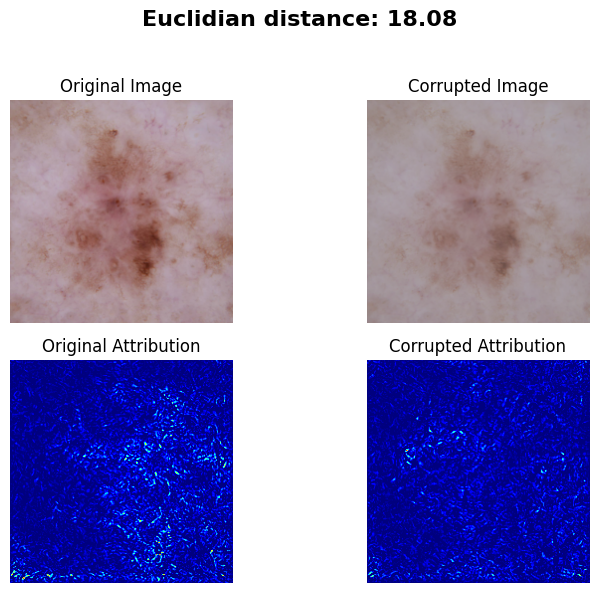

In [14]:
#plot the worst case
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Imposta il titolo generale
fig.suptitle(f"Euclidian distance: {round(max_distance,2)}", fontsize=16, fontweight='bold')

# --- Originale (sinistra) ---
axes[0, 0].imshow(img_original)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[1, 0].imshow(attributions_preprocessing(attribution_original, "both","sum","pos",False,True), cmap='jet')
axes[1, 0].set_title("Original Attribution")
axes[1, 0].axis('off')

# --- Corrupted (destra) ---
axes[0, 1].imshow(img_corrupted)
axes[0, 1].set_title("Corrupted Image")
axes[0, 1].axis('off')

axes[1, 1].imshow(attributions_preprocessing(attribution_corrupted, "both","sum","pos",False,True), cmap='jet')
axes[1, 1].set_title("Corrupted Attribution")
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # lascia spazio per il titolo
plt.show()